# 🩺 Diabetes Disease Progression Prediction using Linear Regression and SHAP

This project builds a regression model to predict disease progression in diabetes patients based on clinical features like BMI, blood pressure, and serum measurements. The model is evaluated using R² and MSE, and interpretability is enhanced using SHAP values to understand feature importance.


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes

# Load the dataset
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name='disease_progression')

print(f"Dataset shape: {X.shape}")
X.head()


Dataset shape: (442, 10)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


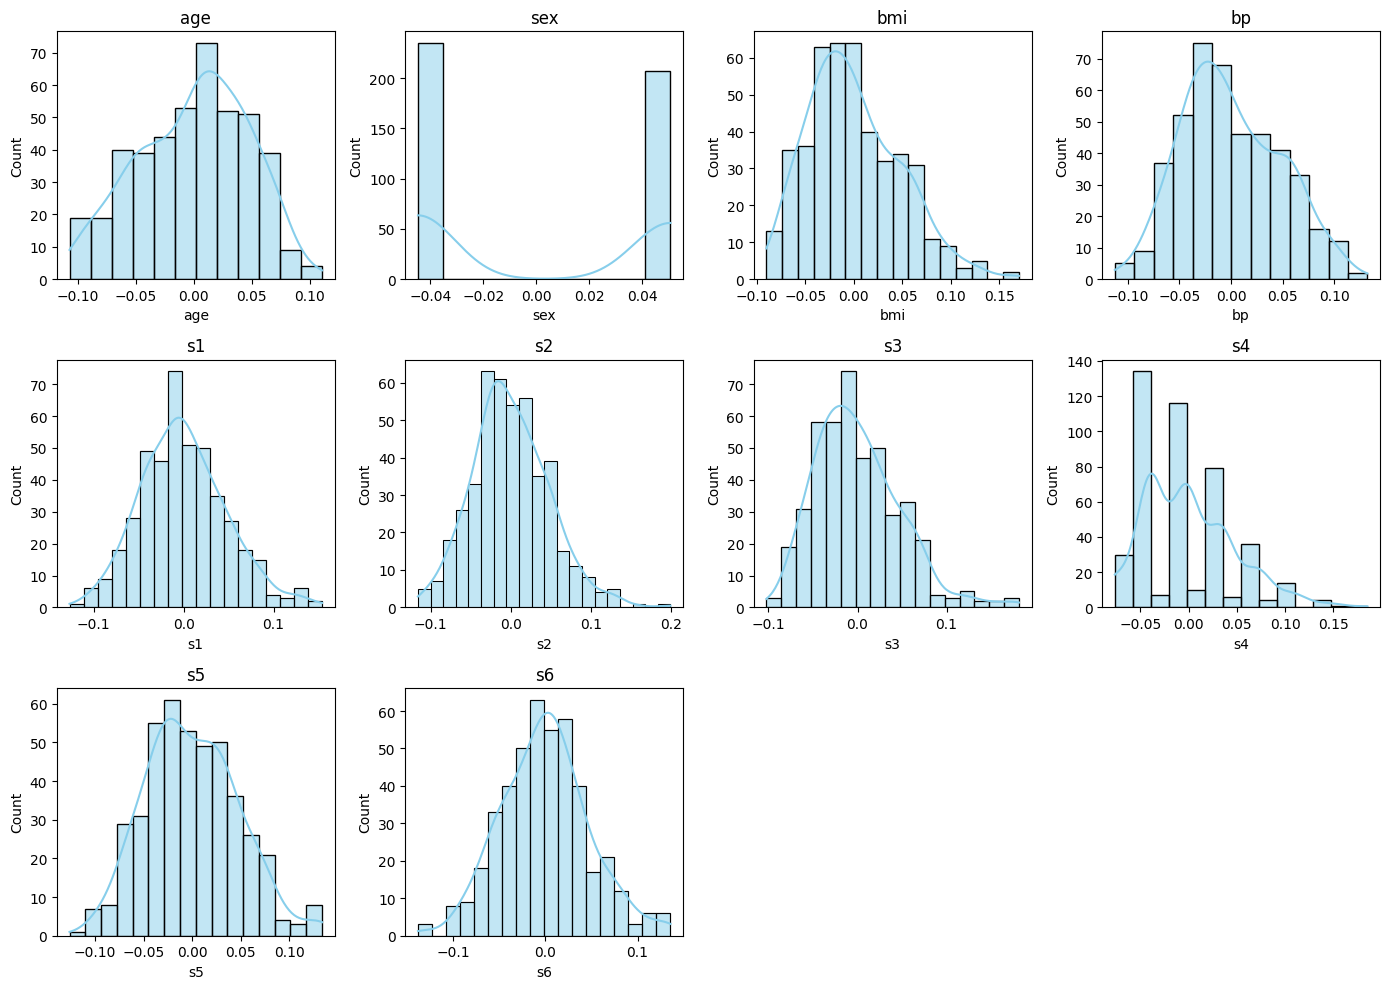

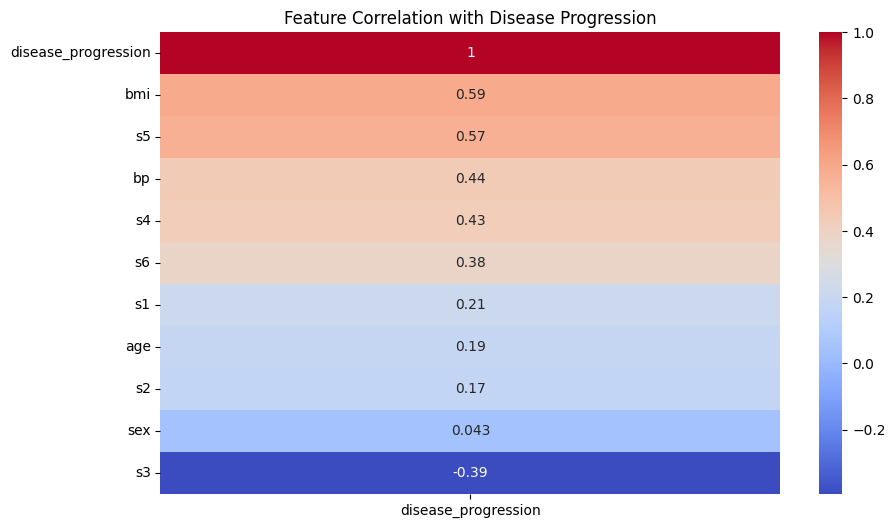

In [30]:
# Plot distributions
plt.figure(figsize=(14, 10))
for i, col in enumerate(X.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(X[col], kde=True, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

# Add target for correlation
df = X.copy()
df['disease_progression'] = y

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr()[['disease_progression']].sort_values(by='disease_progression', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Disease Progression")
plt.show()


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 🔧 Step 4.1: Polynomial Feature Engineering
To capture non-linear feature interactions, we apply degree-2 PolynomialFeatures.


In [38]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


In [41]:
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Train Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_preds = linear_model.predict(X_test_scaled)

# Train Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_preds = ridge_model.predict(X_test_scaled)

# Train XGBoost Regression
xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)




## 📈 Step 6: Cross-Validation for Model Robustness
We use 5-fold cross-validation to validate R² performance across different splits.


In [42]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R²: {scores.mean():.4f}")


Cross-validated R²: 0.4823


In [43]:
# Evaluation Function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return [mse, rmse, mae, r2]

# Collect metrics
linear_metrics = evaluate_model(y_test, linear_preds)
ridge_metrics = evaluate_model(y_test, ridge_preds)
xgb_metrics = evaluate_model(y_test, xgb_preds)

# Combine into a DataFrame
evaluation_df = pd.DataFrame(
    [linear_metrics, ridge_metrics, xgb_metrics],
    columns=["MSE", "RMSE", "MAE", "R² Score"],
    index=["Linear Regression", "Ridge Regression", "XGBoost Regressor"]
)

# Display the comparison table
evaluation_df

,MSE,RMSE,MAE,R² Score
Linear Regression,2900.193628,53.853446,42.794095,0.452603
Ridge Regression,2892.014566,53.777454,42.811999,0.454147
XGBoost Regressor,3351.001638,57.887837,46.388966,0.367515


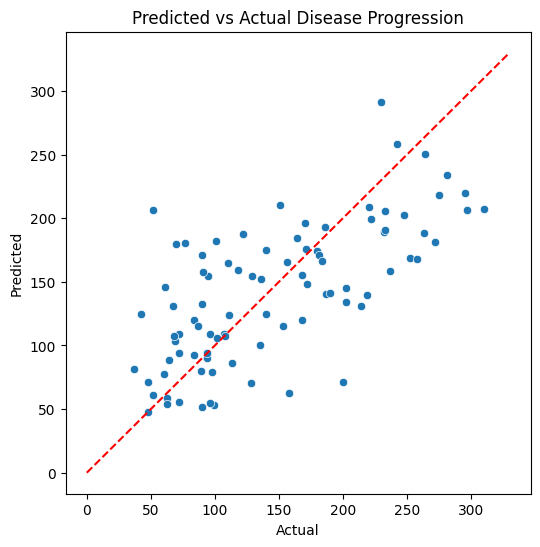

In [34]:
comparison = pd.DataFrame({
    'Predicted': y_pred,
    'Actual': y_test.values
})

plt.figure(figsize=(6, 6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison)
plt.plot([0, 330], [0, 330], 'r--')
plt.title("Predicted vs Actual Disease Progression")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


In [44]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test_scaled, y_test, n_repeats=30)


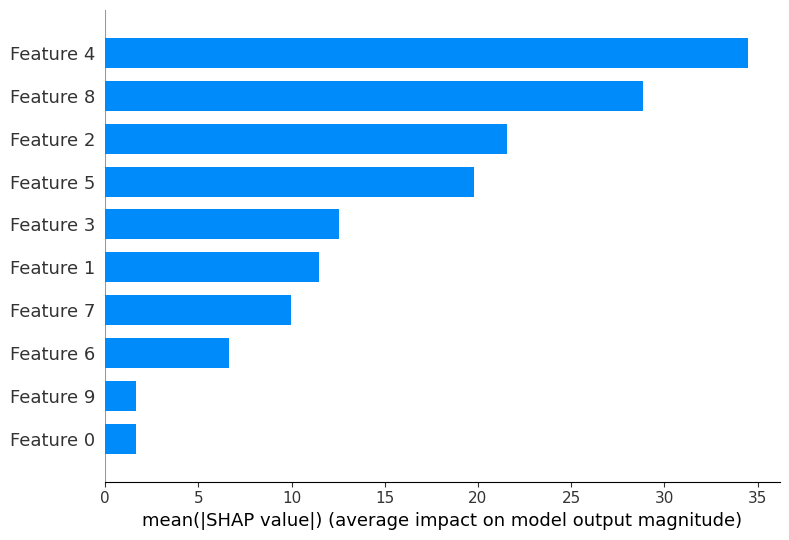

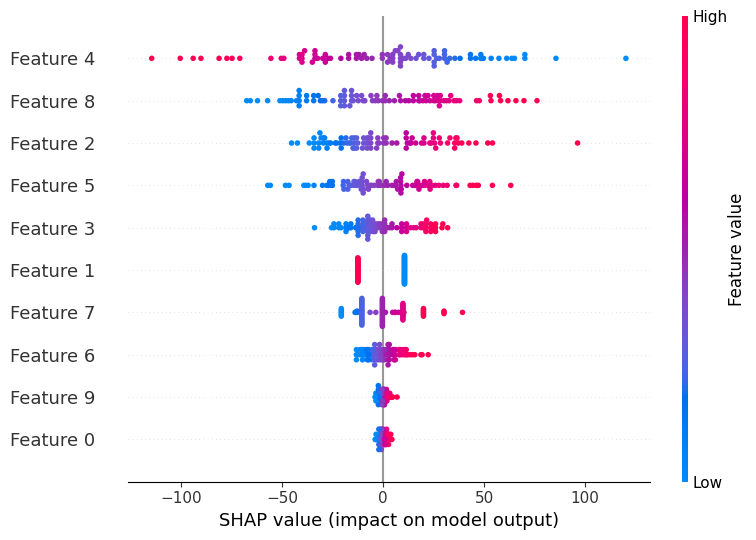

In [36]:
import shap

# SHAP expects the original DataFrame
explainer = shap.Explainer(model.predict, X_test_scaled)
shap_values = explainer(X_test_scaled)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)
